# Predict Customer Churn using XGBoost

In [317]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import os
import pickle

In [318]:
df = pd.read_csv('classificationdata.csv', index_col='id')
df

,state_code,tenure,contract_length,promotions_offered,remaining_term,last_nps_rating,area_code,international_plan,voice_mail_plan,number_vmail_messages,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
id,,,,,,,,,,,,,,,,,,,,,
0,HI,156,14.0,Yes,1.0,6.0,area_code_510,no,no,0,...,108,19.138302,208.349932,130,9.190181,8.015688,7,2.248902,7,no
1,MI,216,8.0,No,14.0,9.0,area_code_408,no,no,3,...,71,15.474436,228.902063,85,10.277852,9.683971,8,2.609739,3,no
2,NH,18,20.0,No,12.0,1.0,area_code_408,no,no,1,...,55,22.547297,202.353527,127,8.898488,14.039450,8,3.845776,2,no
3,MN,174,9.0,No,12.0,6.0,area_code_415,no,no,2,...,105,16.666506,214.487530,105,9.740333,13.031063,4,3.525823,1,no
4,TX,68,19.0,No,22.0,5.0,area_code_415,no,no,1,...,88,20.408969,190.047534,113,8.813303,6.760950,4,1.828652,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17238,NY,142,14.0,No,1.0,1.0,area_code_415,yes,no,2,...,125,14.191124,62.263008,89,2.872740,0.493638,0,0.250048,3,yes
17239,ID,93,8.0,No,9.0,7.0,area_code_415,yes,yes,29,...,134,23.784585,224.625284,95,10.627770,12.870274,6,3.370551,1,no
17240,TX,110,24.0,No,3.0,7.0,area_code_510,no,no,2,...,123,21.482982,146.474026,59,6.367553,14.037650,5,4.001911,4,no


## Split the data into train and test

In [319]:
train, test = train_test_split(df, test_size=0.3, random_state=1234)
X_temp = train.drop('churn', axis=1)
y_temp = train['churn']
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=1234)

# EDA on the training data

In [320]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12070 entries, 16692 to 1318
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state_code                     12070 non-null  object 
 1   tenure                         12070 non-null  int64  
 2   contract_length                12041 non-null  float64
 3   promotions_offered             12041 non-null  object 
 4   remaining_term                 12041 non-null  float64
 5   last_nps_rating                12041 non-null  float64
 6   area_code                      12063 non-null  object 
 7   international_plan             12070 non-null  object 
 8   voice_mail_plan                12050 non-null  object 
 9   number_vmail_messages          12070 non-null  int64  
 10  total_day_minutes              12070 non-null  float64
 11  total_day_calls                12070 non-null  int64  
 12  total_day_charge               12070 non-nu

In [321]:
train.isnull().sum()

state_code                        0
tenure                            0
contract_length                  29
promotions_offered               29
remaining_term                   29
last_nps_rating                  29
area_code                         7
international_plan                0
voice_mail_plan                  20
number_vmail_messages             0
total_day_minutes                 0
total_day_calls                   0
total_day_charge                  0
total_eve_minutes                12
total_eve_calls                   0
total_eve_charge                  0
total_night_minutes               0
total_night_calls                 0
total_night_charge                0
total_intl_minutes                0
total_intl_calls                  0
total_intl_charge                 0
number_customer_service_calls     0
churn                            29
dtype: int64

In [322]:
train.describe()

,tenure,contract_length,remaining_term,last_nps_rating,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,12070.000000,12041.000000,12041.000000,12041.000000,12070.000000,12070.000000,12070.000000,12070.000000,12058.000000,12070.000000,12070.000000,12070.000000,12070.000000,12070.000000,12070.000000,12070.000000,12070.000000,12070.000000
mean,100.310771,15.924840,11.137115,6.102815,8.638608,179.821368,100.064374,30.574659,200.288303,100.416984,17.014347,199.546252,99.791881,8.979010,10.300118,4.961806,2.774743,1.555344
std,39.742023,4.904918,7.212212,2.723722,13.030305,54.694309,20.137844,9.301168,50.899001,19.898596,4.319807,50.871813,20.195931,2.285268,2.804826,2.508605,0.750105,1.317849
min,1.000000,8.000000,1.000000,1.000000,0.000000,1.383902,1.000000,0.119603,7.605489,1.000000,1.052621,4.247707,1.000000,0.472320,0.032252,0.000000,0.013478,0.000000
25%,73.000000,12.000000,5.000000,4.000000,1.000000,142.621175,87.000000,24.323777,166.719227,87.000000,14.152096,165.683627,86.000000,7.446210,8.529475,3.000000,2.299756,1.000000
50%,100.000000,16.000000,10.000000,7.000000,2.000000,179.705079,100.000000,30.517433,200.746807,101.000000,17.049083,198.635687,99.000000,8.952996,10.382980,5.000000,2.812103,1.000000
75%,127.000000,20.000000,17.000000,8.000000,16.000000,217.024361,113.000000,36.834662,233.943152,114.000000,19.870764,234.236992,114.000000,10.520554,12.066125,6.000000,3.256842,2.000000
max,238.000000,24.000000,24.000000,10.000000,52.000000,351.091823,165.000000,59.727092,357.739429,169.000000,30.474658,394.851052,173.000000,17.700351,19.981388,20.000000,5.398333,9.000000


In [323]:
train.describe(include='object')

,state_code,promotions_offered,area_code,international_plan,voice_mail_plan,churn
count,12070,12041,12063,12070,12050,12041
unique,51,3,3,2,2,2
top,WV,No,area_code_415,no,no,no
freq,398,10957,6049,10957,8887,10314


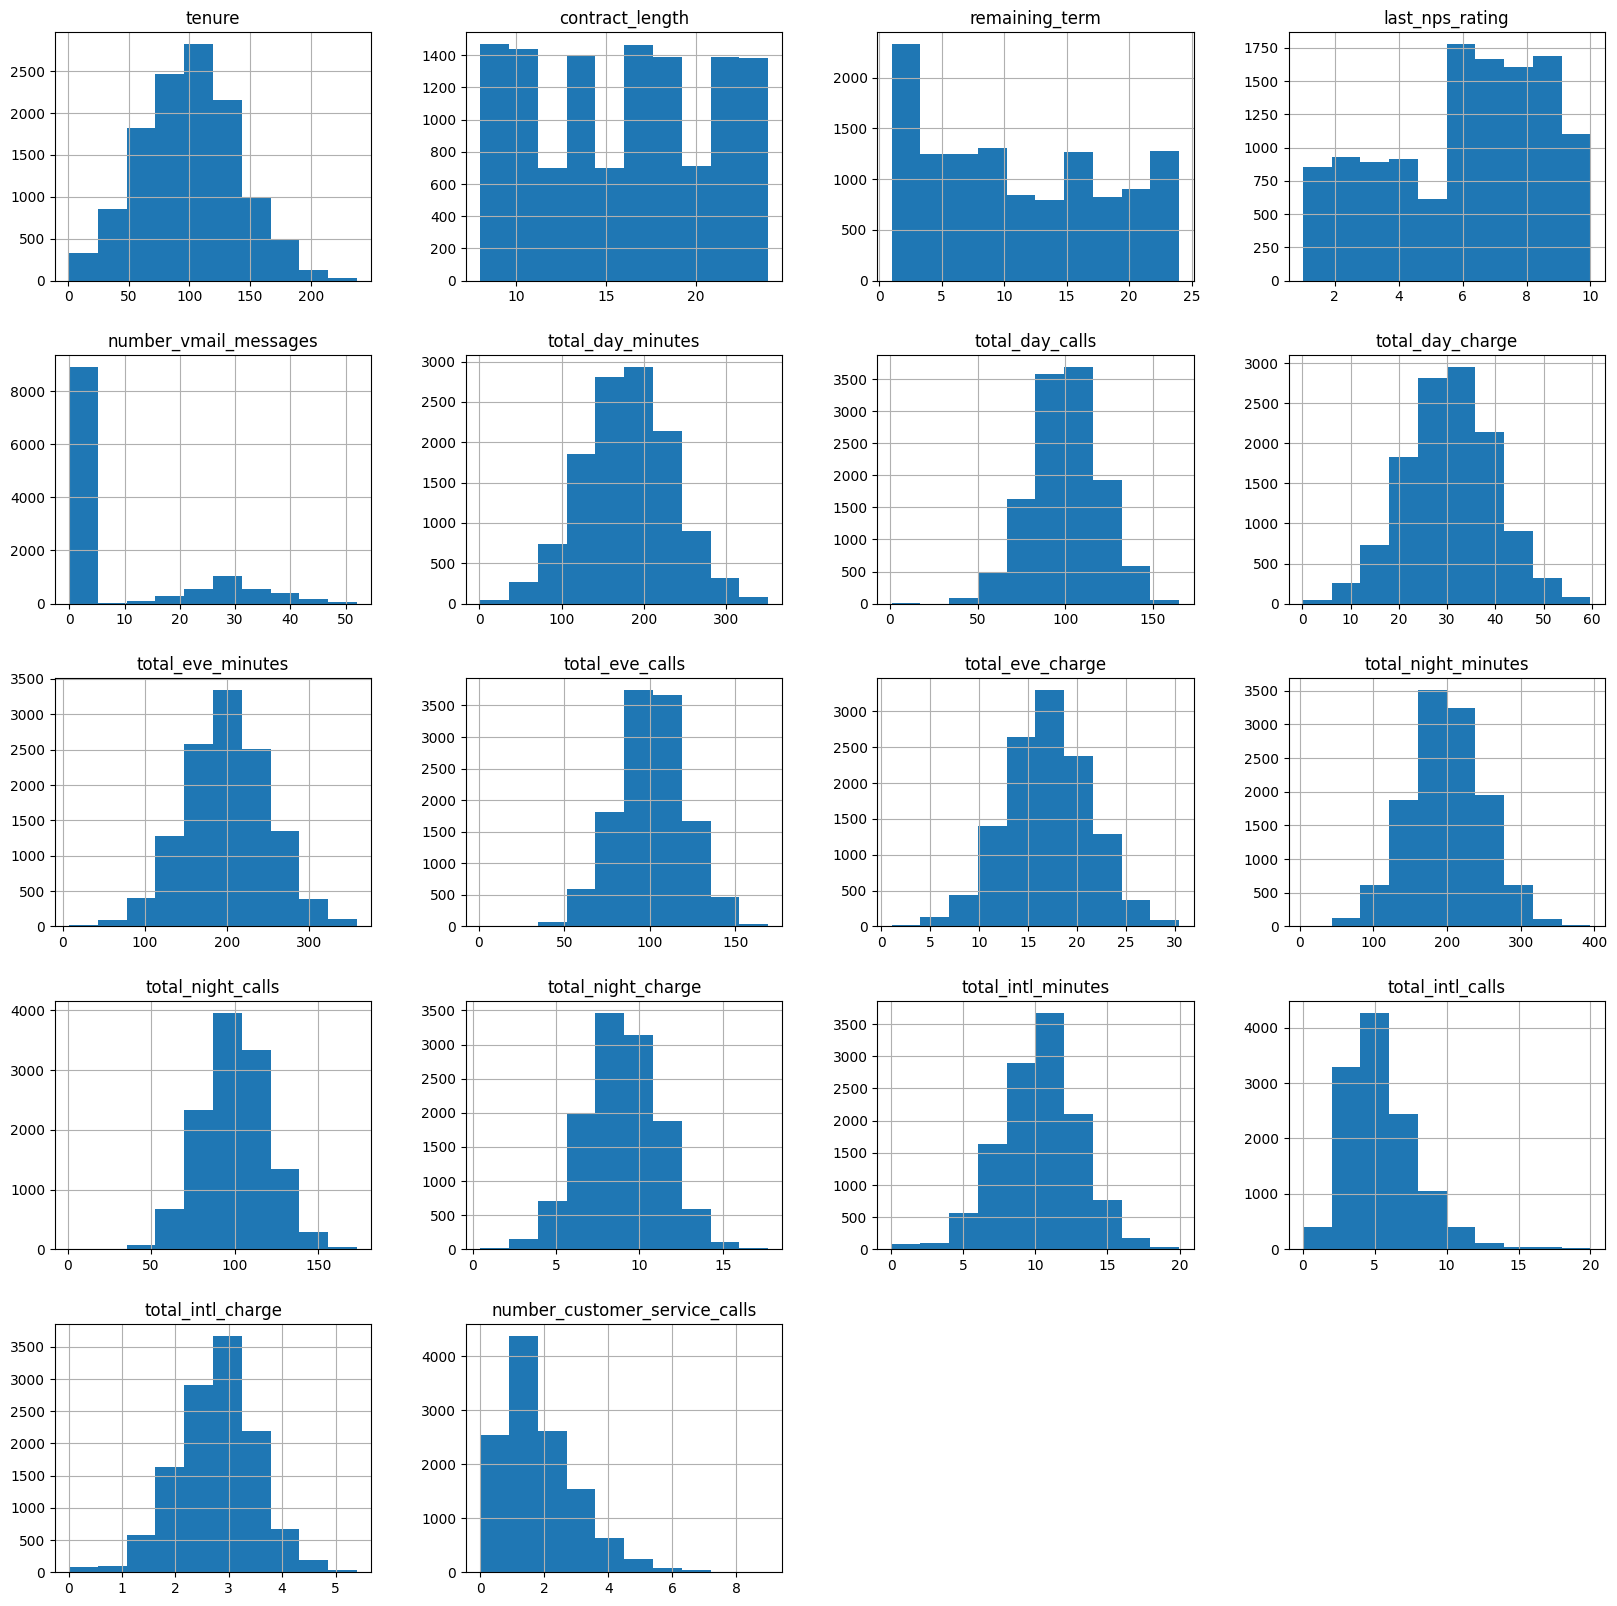

In [324]:
%matplotlib inline
train.hist(figsize=(20,20))
plt.show()

### Response Variable

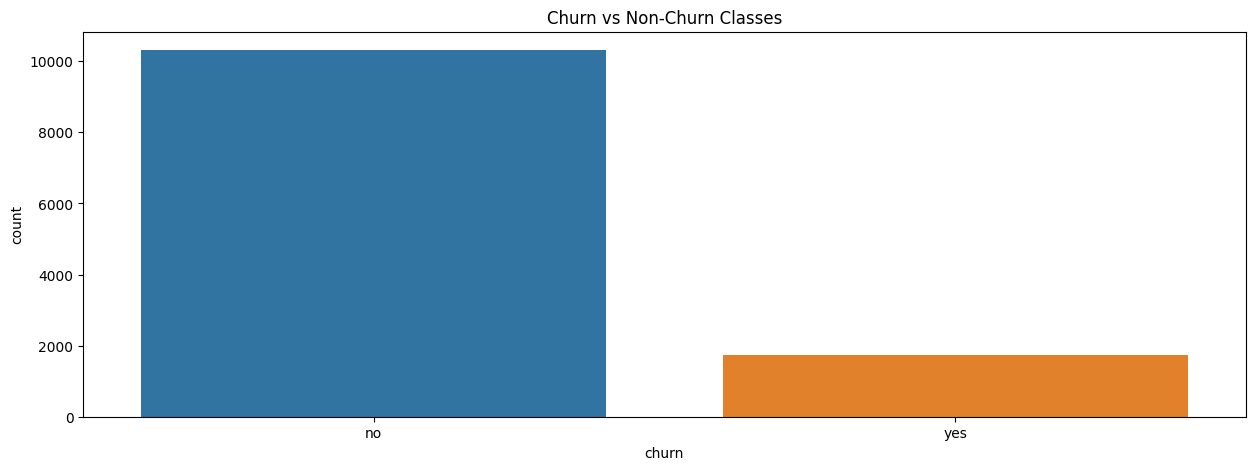

In [325]:
plt.figure(figsize=(15,5))
sns.countplot(x='churn', data=train).set_title('Churn vs Non-Churn Classes')
plt.show()

### State, Area Code, and Promotions Offered

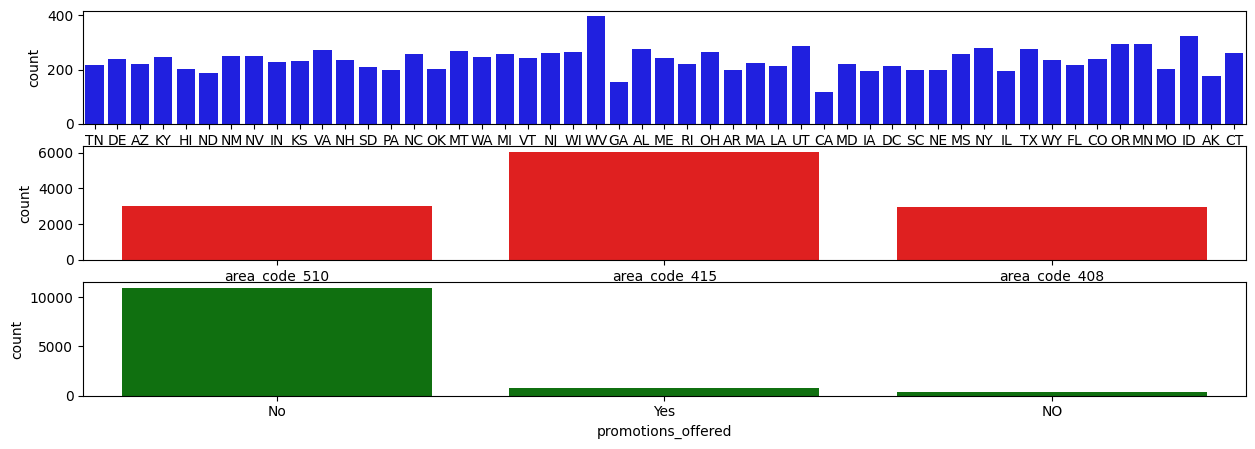

In [326]:
fig, axs = plt.subplots(3, figsize=(15,5))
sns.countplot(data=train, x='state_code', ax=axs[0], color='blue')
sns.countplot(data=train, x='area_code', ax=axs[1], color='red')
sns.countplot(data=train, x='promotions_offered', ax=axs[2], color='green')
plt.show()

### Vmail Messages and Customer Service Calls

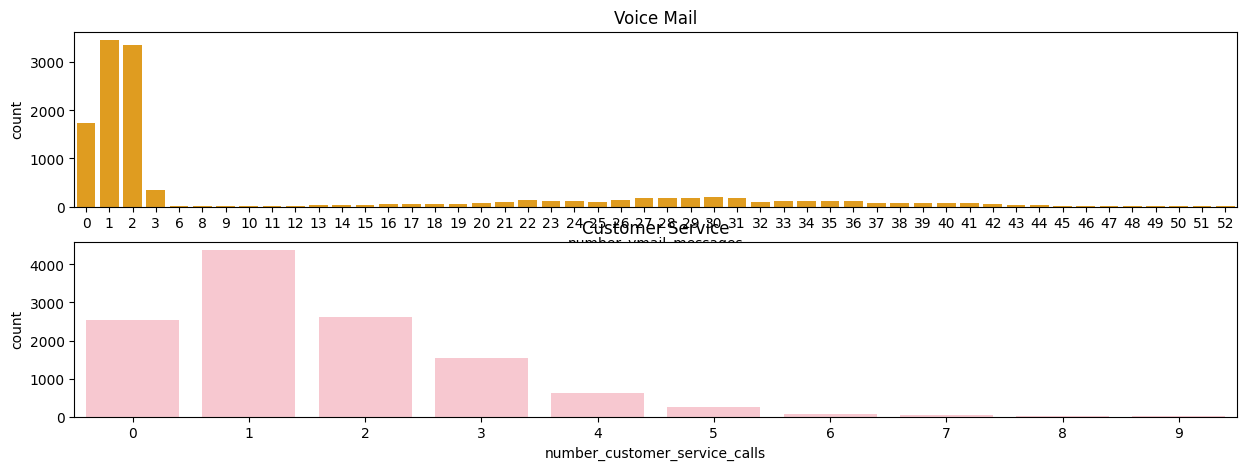

In [327]:
fig, axs = plt.subplots(2, figsize=(15,5))
sns.countplot(x='number_vmail_messages', data=train, ax=axs[0], color='orange').set_title('Voice Mail')
sns.countplot(x='number_customer_service_calls', data=train, ax=axs[1], color='pink').set_title('Customer Service')
plt.show()

In [328]:
train['number_customer_service_calls'].skew()

1.086776733503893

Would log transform help?

-0.11828354478767099


array([[<AxesSubplot: title={'center': 'number_customer_service_calls'}>,
        <AxesSubplot: title={'center': 'log_customer_service_calls'}>]],
      dtype=object)

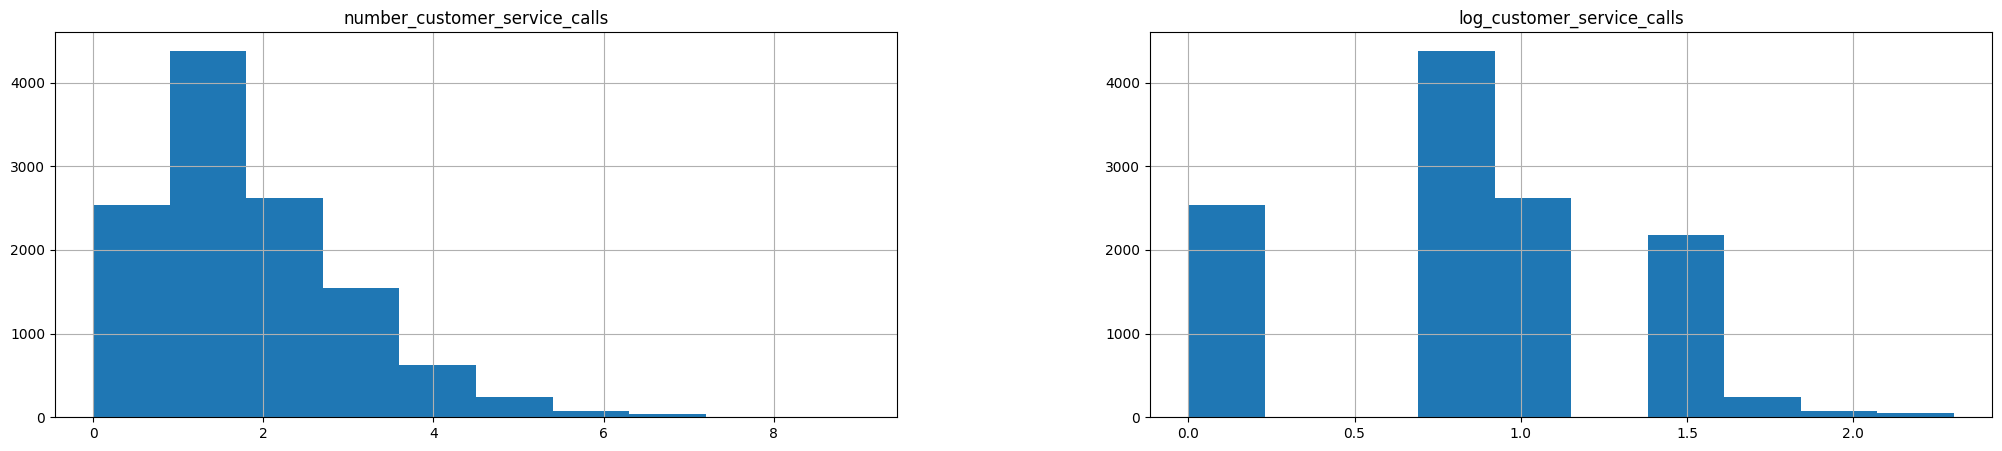

In [329]:
train['log_customer_service_calls'] = np.log(train['number_customer_service_calls'] + 1)
print(train['log_customer_service_calls'].skew())
train[['number_customer_service_calls', 'log_customer_service_calls']].hist(figsize=(25,5))

Yes, that helped a lot. Now removing the row we just made so we can only include changes to the dataset in the data preprocessing section.

In [330]:
train = train.drop('log_customer_service_calls', axis=1)

### Correlation Plot 

Text(0.5, 1.0, 'Correlation Plot')

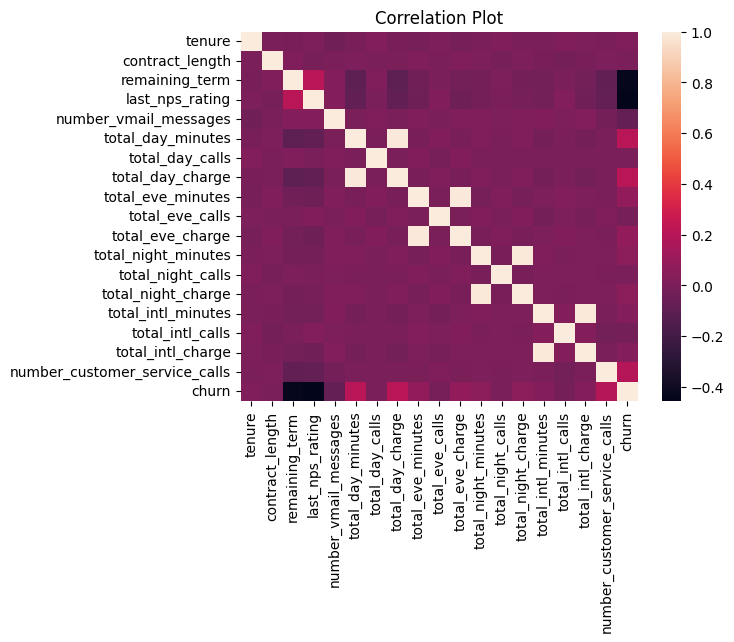

In [331]:
temp = train.copy()
temp['churn'] = temp['churn'].apply(lambda x: 1 if x == 'yes' else 0)
sns.heatmap(temp.select_dtypes(exclude='object').corr()).set_title('Correlation Plot')

## Find Unhappy Customers

In [332]:
train['promotions_offered'] = train['promotions_offered'].replace(['NO', np.NaN], 'No')
pivot_feature = 'promotions_offered'
pd.crosstab(train[pivot_feature], train['churn']) / len(train)

churn,no,yes
promotions_offered,,
No,0.822038,0.115659
Yes,0.032477,0.027423


In [333]:
for col in train.select_dtypes(include='object').columns:
    if col != 'churn':
        display(pd.crosstab(train[col], train['churn']) / len(train))

churn,no,yes
state_code,,
AK,0.013670,0.000829
AL,0.019553,0.002900
AR,0.014167,0.002403
AZ,0.016321,0.001657
CA,0.007539,0.002237
CO,0.017647,0.002237
CT,0.018558,0.003231
DC,0.014250,0.003065
DE,0.016239,0.003480


churn,no,yes
promotions_offered,,
No,0.822038,0.115659
Yes,0.032477,0.027423


churn,no,yes
area_code,,
area_code_408,0.210025,0.036205
area_code_415,0.430655,0.069097
area_code_510,0.213256,0.037780


churn,no,yes
international_plan,,
no,0.796935,0.108451
yes,0.057581,0.034631


churn,no,yes
voice_mail_plan,,
no,0.616321,0.118973
yes,0.237117,0.023529


### Relationship between Remaining term and NPS Rating? And...promotions offered? Namely when Remaining term < 5 and Last nps rating < 7

In [334]:
train['nps_less_7'] = (train['last_nps_rating'] < 7).astype(int)
train['remaining_term_less_5'] = (train['remaining_term'] < 5).astype(int)
train['churn_yes'] = train['churn'].apply(lambda x: 1 if x == 'yes' else 0)
train['churn_no'] = train['churn'].apply(lambda x: 0 if x == 'yes' else 1)
train.groupby(['nps_less_7', 'remaining_term_less_5']).sum(['churn_yes', 'churn_no'])[['churn_yes', 'churn_no']] / len(train)

churn_yes  churn_no
nps_less_7 remaining_term_less_5                     
0          0                       0.002320  0.412428
           1                       0.005385  0.084341
1          0                       0.041011  0.298260
           1                       0.094366  0.061889

9% of customers churned when nps was less than 7 and they had less than 5 terms left. That's a lot

In [335]:
train.groupby(['nps_less_7', 'remaining_term_less_5', 'promotions_offered']).sum(['churn_yes', 'churn_no'])[['churn_yes', 'churn_no']] / len(train)

churn_yes  churn_no
nps_less_7 remaining_term_less_5 promotions_offered                     
0          0                     No                   0.001988  0.412428
                                 Yes                  0.000331  0.000000
           1                     No                   0.004225  0.084341
                                 Yes                  0.001160  0.000000
1          0                     No                   0.033554  0.298260
                                 Yes                  0.007457  0.000000
           1                     No                   0.075891  0.029412
                                 Yes                  0.018476  0.032477

8% of customers churned when nps was less than 7, had less than 5 terms left, and they were NOT offered a promotion. When that same group of customers WAS offered a promotion, 3% did not churn and 2% did.

Keeping all changes to data in the Data Preprocessing section to help with organization, need to return data to original form

In [336]:
train.drop(['nps_less_7', 'remaining_term_less_5', 'churn_yes', 'churn_no'], axis=1, inplace=True)

# Data Preprocessing

## Missing Values

### area_code - fill with 'missing'

In [337]:
train['area_code'] = train['area_code'].fillna('missing')
train[train['area_code'] == 'missing']

,state_code,tenure,contract_length,promotions_offered,remaining_term,last_nps_rating,area_code,international_plan,voice_mail_plan,number_vmail_messages,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
id,,,,,,,,,,,,,,,,,,,,,
17168,WY,54,18.0,No,19.0,7.0,missing,no,NaN,40,...,111,16.548064,193.086752,114,8.808353,9.344790,4,2.634894,0,no
4558,WY,58,22.0,No,20.0,6.0,missing,no,NaN,41,...,111,15.370818,185.992442,115,8.634951,9.258257,4,2.522559,0,no
13336,RI,79,13.0,No,9.0,6.0,missing,no,no,2,...,68,14.943610,162.052384,106,7.171747,13.576263,6,3.658442,1,no
5772,MO,155,12.0,No,3.0,9.0,missing,yes,no,0,...,98,8.018185,200.103367,96,9.318969,7.688405,7,1.940647,0,no
1642,MO,154,15.0,No,2.0,7.0,missing,yes,no,1,...,100,8.753738,198.839157,94,9.278937,7.073209,6,1.943637,0,no
16450,FL,147,16.0,No,9.0,8.0,missing,yes,no,1,...,93,20.838636,187.249514,66,8.307897,8.289207,5,2.255682,2,no
12972,MO,153,24.0,No,13.0,6.0,missing,yes,no,0,...,98,8.515226,207.015705,92,9.090795,7.466579,6,2.008288,0,no


### voice_mail_plan - fill with 'missing'

In [338]:
train['voice_mail_plan'] = train['voice_mail_plan'].fillna('missing')
train[train['voice_mail_plan'] == 'missing']

,state_code,tenure,contract_length,promotions_offered,remaining_term,last_nps_rating,area_code,international_plan,voice_mail_plan,number_vmail_messages,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
id,,,,,,,,,,,,,,,,,,,,,
16429,HI,44,21.0,No,20.0,10.0,area_code_510,no,missing,1,...,102,18.016167,187.208784,90,8.690546,11.481874,2,3.017702,1,no
10372,HI,42,8.0,No,7.0,6.0,area_code_510,no,missing,2,...,106,17.749234,185.584080,92,8.224325,11.041335,2,3.105547,1,no
11974,MO,15,14.0,No,17.0,9.0,area_code_510,no,missing,1,...,69,11.871465,145.341081,102,7.051341,8.259750,9,2.296696,1,no
3365,MO,18,22.0,No,12.0,2.0,area_code_415,no,missing,2,...,77,22.896967,178.095650,103,8.785522,6.028258,6,1.874301,0,no
17168,WY,54,18.0,No,19.0,7.0,missing,no,missing,40,...,111,16.548064,193.086752,114,8.808353,9.344790,4,2.634894,0,no
7767,AZ,4,9.0,No,7.0,3.0,area_code_408,no,missing,0,...,119,21.481234,281.874501,91,12.695069,11.408316,4,3.225750,1,yes
16037,AZ,6,16.0,No,3.0,2.0,area_code_408,no,missing,2,...,122,22.108010,288.967333,88,13.270796,11.430051,3,3.059472,1,yes
4558,WY,58,22.0,No,20.0,6.0,missing,no,missing,41,...,111,15.370818,185.992442,115,8.634951,9.258257,4,2.522559,0,no
8645,MT,60,17.0,Yes,1.0,4.0,area_code_415,no,missing,1,...,75,19.991544,180.150988,108,8.345667,9.549767,3,2.468519,1,yes


### total_eve_minutes - fill with mean

In [339]:
mean_eve_mins = train['total_eve_minutes'].mean().round(2)
train['total_eve_minutes_missing'] = train['total_eve_minutes'].isnull().astype(int)
train['total_eve_minutes'] = train['total_eve_minutes'].fillna(mean_eve_mins)
train[train['total_eve_minutes_missing'] == 1][['total_eve_minutes_missing', 'total_eve_minutes']]

,total_eve_minutes_missing,total_eve_minutes
id,,
16142,1,200.29
17168,1,200.29
4558,1,200.29
11193,1,200.29
15828,1,200.29
12703,1,200.29
2729,1,200.29
11475,1,200.29
15905,1,200.29


### churn - drop b/c response variable

In [340]:
train = train[~train['churn'].isnull()]
train.isnull().sum()

state_code                       0
tenure                           0
contract_length                  0
promotions_offered               0
remaining_term                   0
last_nps_rating                  0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
total_eve_minutes_missing        0
dtype: int64

No more missing values!

# Feature Engineering

## Ratio for Correlated Predictor Variables

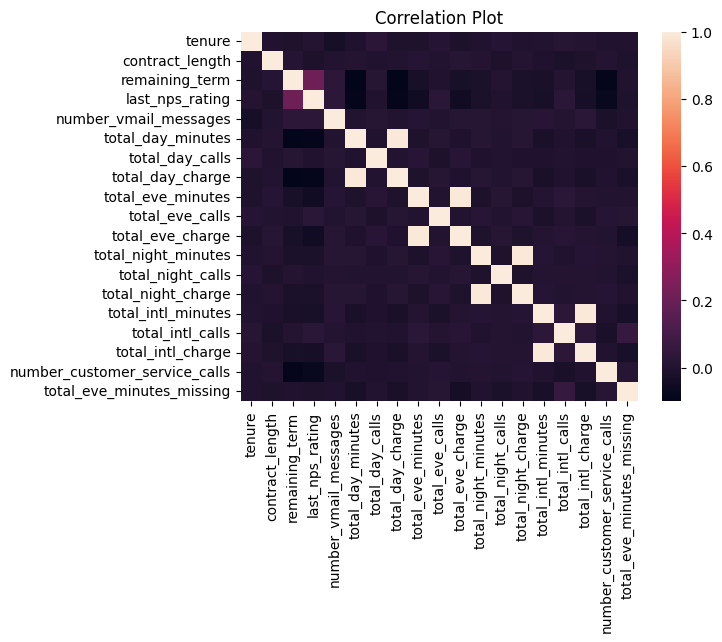

In [341]:
sns.heatmap(train.select_dtypes(exclude='object').corr()).set_title('Correlation Plot')
plt.show()

In [342]:
train['day_ratio'] = train['total_day_charge'] / train['total_day_minutes']
train['eve_ratio'] = train['total_eve_charge'] / train['total_eve_minutes']
train['night_ratio'] = train['total_night_charge'] / train['total_night_minutes']
train['intl_ratio'] = train['total_intl_charge'] / train['total_intl_minutes']
train.head()

,state_code,tenure,contract_length,promotions_offered,remaining_term,last_nps_rating,area_code,international_plan,voice_mail_plan,number_vmail_messages,...,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_eve_minutes_missing,day_ratio,eve_ratio,night_ratio,intl_ratio
id,,,,,,,,,,,,,,,,,,,,,
16692,TN,100,18.0,No,23.0,9.0,area_code_510,no,no,2,...,8.308312,9,2.208759,2,no,0,0.172815,0.083632,0.043008,0.265849
6970,DE,92,15.0,No,7.0,7.0,area_code_510,no,no,0,...,8.238645,2,2.168779,1,yes,0,0.169215,0.084485,0.045763,0.263245
9747,AZ,62,10.0,No,18.0,10.0,area_code_415,no,yes,20,...,11.084169,5,3.153671,0,no,0,0.158396,0.088938,0.046510,0.284520
16099,KY,143,12.0,No,12.0,6.0,area_code_408,no,no,1,...,19.981388,4,5.242569,0,no,0,0.178475,0.086951,0.043587,0.262373
8833,HI,123,19.0,No,23.0,7.0,area_code_510,no,no,0,...,11.670808,9,3.205746,2,no,0,0.168656,0.081817,0.043780,0.274681


In [343]:
train = train.drop(['total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes', 'total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge'], axis=1)
train.columns

Index(['state_code', 'tenure', 'contract_length', 'promotions_offered',
       'remaining_term', 'last_nps_rating', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_calls',
       'total_eve_calls', 'total_night_calls', 'total_intl_calls',
       'number_customer_service_calls', 'churn', 'total_eve_minutes_missing',
       'day_ratio', 'eve_ratio', 'night_ratio', 'intl_ratio'],
      dtype='object')

## Skewed Customer Service Calls

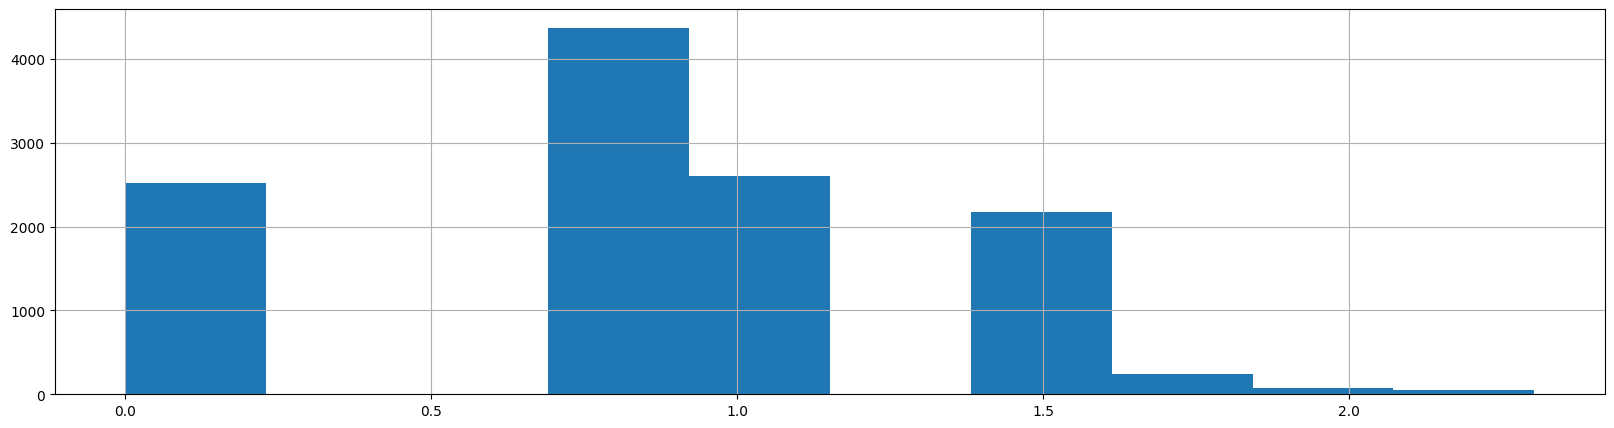

In [344]:
train['number_customer_service_calls'] = np.log(train['number_customer_service_calls'] + 1)
train['number_customer_service_calls'].hist(figsize=(20,5))
plt.show()

## Promotions Offered weirdness

In [345]:
train['promotions_offered'] = train['promotions_offered'].replace(['NO', np.NaN], 'No')
train.isnull().sum()

state_code                       0
tenure                           0
contract_length                  0
promotions_offered               0
remaining_term                   0
last_nps_rating                  0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_calls                  0
total_eve_calls                  0
total_night_calls                0
total_intl_calls                 0
number_customer_service_calls    0
churn                            0
total_eve_minutes_missing        0
day_ratio                        0
eve_ratio                        0
night_ratio                      0
intl_ratio                       0
dtype: int64

## Create unhappy_customer variable

When remaining_term < 5, last_nps_rating <= 7, and promotions_offered = 0, then unhappy_customer = 1

In [346]:
train['unhappy_customer'] = ((train.remaining_term < 5) & (train.last_nps_rating <= 7) & (train.promotions_offered == 'No')).astype(int)

# Create Target and Feature Variables

In [347]:
X_train = train.drop('churn', axis=1)
y_train = np.where(train['churn'] == 'yes', 1, 0)
print('churn' in list(X_train.columns))
y_train

False


array([0, 1, 0, ..., 0, 0, 0])

## One Hot Encode Categorical Variables

In [348]:
onehot = OneHotEncoder(handle_unknown='ignore')
encoded_columns = onehot.fit_transform(X_train.select_dtypes(include='object')).toarray()
onehot.get_feature_names_out()

array(['state_code_AK', 'state_code_AL', 'state_code_AR', 'state_code_AZ',
       'state_code_CA', 'state_code_CO', 'state_code_CT', 'state_code_DC',
       'state_code_DE', 'state_code_FL', 'state_code_GA', 'state_code_HI',
       'state_code_IA', 'state_code_ID', 'state_code_IL', 'state_code_IN',
       'state_code_KS', 'state_code_KY', 'state_code_LA', 'state_code_MA',
       'state_code_MD', 'state_code_ME', 'state_code_MI', 'state_code_MN',
       'state_code_MO', 'state_code_MS', 'state_code_MT', 'state_code_NC',
       'state_code_ND', 'state_code_NE', 'state_code_NH', 'state_code_NJ',
       'state_code_NM', 'state_code_NV', 'state_code_NY', 'state_code_OH',
       'state_code_OK', 'state_code_OR', 'state_code_PA', 'state_code_RI',
       'state_code_SC', 'state_code_SD', 'state_code_TN', 'state_code_TX',
       'state_code_UT', 'state_code_VA', 'state_code_VT', 'state_code_WA',
       'state_code_WI', 'state_code_WV', 'state_code_WY',
       'promotions_offered_No', 'promotion

In [349]:
X_train = X_train.select_dtypes(exclude='object')
X_train[onehot.get_feature_names_out()] = encoded_columns
X_train.columns

Index(['tenure', 'contract_length', 'remaining_term', 'last_nps_rating',
       'number_vmail_messages', 'total_day_calls', 'total_eve_calls',
       'total_night_calls', 'total_intl_calls',
       'number_customer_service_calls', 'total_eve_minutes_missing',
       'day_ratio', 'eve_ratio', 'night_ratio', 'intl_ratio',
       'unhappy_customer', 'state_code_AK', 'state_code_AL', 'state_code_AR',
       'state_code_AZ', 'state_code_CA', 'state_code_CO', 'state_code_CT',
       'state_code_DC', 'state_code_DE', 'state_code_FL', 'state_code_GA',
       'state_code_HI', 'state_code_IA', 'state_code_ID', 'state_code_IL',
       'state_code_IN', 'state_code_KS', 'state_code_KY', 'state_code_LA',
       'state_code_MA', 'state_code_MD', 'state_code_ME', 'state_code_MI',
       'state_code_MN', 'state_code_MO', 'state_code_MS', 'state_code_MT',
       'state_code_NC', 'state_code_ND', 'state_code_NE', 'state_code_NH',
       'state_code_NJ', 'state_code_NM', 'state_code_NV', 'state_code_NY',


# Imbalanced Classes

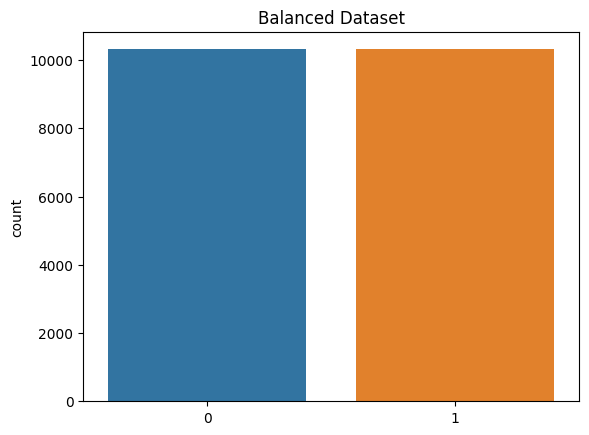

In [350]:
sm = SMOTE(random_state=1234)
#Resample to balance the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)
sns.countplot(x=y_train).set_title('Balanced Dataset')
plt.show()

# Model - XGBoost Classifier

## Grid Search for Best Parameters

In [351]:
# param_grid = {
#     'n_estimators': [50, 100, 200, 300],
#     'max_depth': [None, 3, 5, 7, 9]
# }
# model = XGBClassifier()
# grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)

In [352]:
#grid_search.best_params_

In [353]:
model = XGBClassifier(max_depth=9, n_estimators=50)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Evaluation

## Apply Transformations to Test Data

In [354]:
col_order = X_train.columns; col_order

Index(['tenure', 'contract_length', 'remaining_term', 'last_nps_rating',
       'number_vmail_messages', 'total_day_calls', 'total_eve_calls',
       'total_night_calls', 'total_intl_calls',
       'number_customer_service_calls', 'total_eve_minutes_missing',
       'day_ratio', 'eve_ratio', 'night_ratio', 'intl_ratio',
       'unhappy_customer', 'state_code_AK', 'state_code_AL', 'state_code_AR',
       'state_code_AZ', 'state_code_CA', 'state_code_CO', 'state_code_CT',
       'state_code_DC', 'state_code_DE', 'state_code_FL', 'state_code_GA',
       'state_code_HI', 'state_code_IA', 'state_code_ID', 'state_code_IL',
       'state_code_IN', 'state_code_KS', 'state_code_KY', 'state_code_LA',
       'state_code_MA', 'state_code_MD', 'state_code_ME', 'state_code_MI',
       'state_code_MN', 'state_code_MO', 'state_code_MS', 'state_code_MT',
       'state_code_NC', 'state_code_ND', 'state_code_NE', 'state_code_NH',
       'state_code_NJ', 'state_code_NM', 'state_code_NV', 'state_code_NY',


### Make template function that applies all transformations

In [355]:
#template function
def transform_data(test_df, col_order, mean_eve_mins, onehot):
    X = test_df.copy()
    #DP
    X['area_code'] = X['area_code'].fillna('missing')
    X['voice_mail_plan'] = X['voice_mail_plan'].fillna('missing')
    X['total_eve_minutes_missing'] = X['total_eve_minutes'].isnull().astype(int)
    X['total_eve_minutes'] = X['total_eve_minutes'].fillna(mean_eve_mins)
    #FE - ratios
    X['day_ratio'] = X['total_day_charge'] / X['total_day_minutes']
    X['eve_ratio'] = X['total_eve_charge'] / X['total_eve_minutes']
    X['night_ratio'] = X['total_night_charge'] / X['total_night_minutes']
    X['intl_ratio'] = X['total_intl_charge'] / X['total_intl_minutes']
    X = X.drop(['total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes', 'total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge'], axis=1)
    #FE - log transform
    X['number_customer_service_calls'] = np.log(X['number_customer_service_calls'] + 1)
    #FE - promotions offered
    X['promotions_offered'] = X['promotions_offered'].replace(['NO', np.NaN], 'No')
    #FE - unhappy customer
    X['unhappy_customer'] = ((X.remaining_term < 5) & (X.last_nps_rating <= 7) & (X.promotions_offered == 'No')).astype(int)
    #one hot encoding
    encoded_columns = onehot.transform(X.select_dtypes(include='object')).toarray()
    X = X.select_dtypes(exclude='object')
    X[onehot.get_feature_names_out()] = encoded_columns
    return X[col_order]

In [356]:
test = test[~test['churn'].isnull()]
test.isnull().sum()

state_code                        0
tenure                            0
contract_length                   0
promotions_offered                0
remaining_term                    0
last_nps_rating                   0
area_code                         5
international_plan                0
voice_mail_plan                  10
number_vmail_messages             0
total_day_minutes                 0
total_day_calls                   0
total_day_charge                  0
total_eve_minutes                 6
total_eve_calls                   0
total_eve_charge                  0
total_night_minutes               0
total_night_calls                 0
total_night_charge                0
total_intl_minutes                0
total_intl_calls                  0
total_intl_charge                 0
number_customer_service_calls     0
churn                             0
dtype: int64

### Apply template function

In [357]:
test.columns

Index(['state_code', 'tenure', 'contract_length', 'promotions_offered',
       'remaining_term', 'last_nps_rating', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')

In [358]:
X_test = transform_data(test.drop('churn', axis=1), col_order, mean_eve_mins, onehot)
X_test

,tenure,contract_length,remaining_term,last_nps_rating,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls,...,promotions_offered_Yes,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,area_code_missing,international_plan_no,international_plan_yes,voice_mail_plan_missing,voice_mail_plan_no,voice_mail_plan_yes
id,,,,,,,,,,,,,,,,,,,,,
15297,75,13.0,3.0,9.0,1,121,63,97,6,1.386294,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7075,150,17.0,5.0,9.0,1,111,78,88,4,0.693147,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3733,87,11.0,6.0,9.0,2,132,95,49,2,0.693147,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
10674,110,9.0,19.0,6.0,1,85,116,90,3,0.693147,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7360,132,23.0,2.0,1.0,0,101,90,93,8,0.693147,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,44,24.0,9.0,10.0,2,71,104,113,3,1.386294,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
7101,113,22.0,17.0,9.0,1,112,76,97,6,0.693147,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7062,111,22.0,24.0,9.0,16,78,121,105,8,0.693147,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [359]:
y_test = np.where(test['churn'] == 'yes', 1, 0)
np.sum(y_test)

741

### Evaluate Performance

In [360]:
#print accuracy, precision, and recall scores
print('Accuracy: ', accuracy_score(y_test, model.predict(X_test)))
print('Precision: ', precision_score(y_test, model.predict(X_test)))
print('Recall: ', recall_score(y_test, model.predict(X_test)))

Accuracy:  0.9526673132880699
Precision:  0.8465829846582985
Recall:  0.8191632928475033


In [361]:
yhat = model.predict(X_test)
confusion_matrix(y_test, yhat, labels=[1,0])

array([[ 607,  134],
       [ 110, 4304]])

# Deployment

In [362]:
#create file path
SAVE_PATH = os.path.join('models', 'experiment_1')
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [363]:
#save model
FILE_NAME = os.path.join(SAVE_PATH, 'xgb.pkl')
with open(FILE_NAME, 'wb') as f:
    pickle.dump(model, f)

In [364]:
#save one hot encoder
ENCODER_FILE_PATH = os.path.join(SAVE_PATH, 'encoder.pkl')
with open(ENCODER_FILE_PATH, 'wb') as f:
    pickle.dump(onehot, f)

## Create a Model Schema

In [365]:
#value extraction function
def extract_column_values(col, df):
    if df[col].dtype == 'O':
        return list(df[col].unique())
    elif df[col].dtype == 'int64':
        return (int(df[col].min()),int(df[col].max()))
    elif df[col].dtype == 'float64':
        return (float(df[col].min()),float(df[col].max()))
    else:
        return list(df[col].unique().astype(str))

In [366]:
#column value extraction
column_info = {col:{'dtype':str(df[col].dtype), 'values':extract_column_values(col, df)} for col in df.columns}

In [367]:
transformed_cols = {'transformed_columns':X_train.columns.to_list()}
schema = {'column_info':column_info, 'transformed_columns':transformed_cols}

In [368]:
import json
with open(os.path.join('app', 'schema.json'), 'w') as f:
          json.dump(schema, f)